# $\mathrm{IPRCHO}$ (isobutyraldehyde)

In [1]:
using Pkg 
Pkg.activate("../")

  Activating project at `~/gitrepos/activepure/Photolysis.jl/mcm`


In [2]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 
using KernelFunctions
using ParameterHandling

In [3]:
include("./utils.jl")

filter_outliers (generic function with 1 method)

In [4]:
# load in spectrometer data
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [5]:
# http://chmlin9.leeds.ac.uk/MCMv3.3.1/parameters/photolysis/i_C3H7CHO/i_c3h7cho_chen02_hco%20_qy_298.txt

data = [
280	0.85
285	1.01
290	0.95
295	0.98
300	0.92
305	0.95
310	0.98
315	0.04
320	0.028
325	0.021
330	0.023
]

λ = data[:,1]
Φ = data[:,2]
T = [298.0 for _ ∈ 1:size(λ,1)]

11-element Vector{Float64}:
 298.0
 298.0
 298.0
 298.0
 298.0
 298.0
 298.0
 298.0
 298.0
 298.0
 298.0

# Model Evaluation

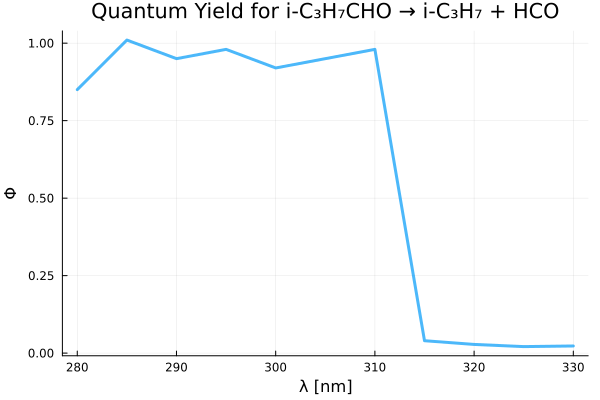

In [6]:
p = plot(
    λ,
    Φ,
    xlabel="λ [nm]",
    ylabel="Φ",
    alpha=0.7,
    lw=3,
    label="",
    title="Quantum Yield for i-C₃H₇CHO → i-C₃H₇ + HCO"
)

# Output for Photolysis Rate Determination

In [7]:
df_photolysis_Φ = CSV.File("../photolysis_Φ.csv") |> DataFrame

Row,Φ_1,Φ_2,Φ_3,Φ_4,Φ_6,Φ_5,Φ_7,Φ_8,Φ_11,Φ_12,Φ_13,Φ_14,Φ_15,Φ_16
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
6,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
7,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
8,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
9,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [8]:
λ_min = minimum(λ)
λ_max = maximum(λ)

#println(λ_min, "\t", minimum(df_photolysis_σ.λ))
#println(λ_max, "\t", maximum(df_photolysis_σ.λ))

330.0

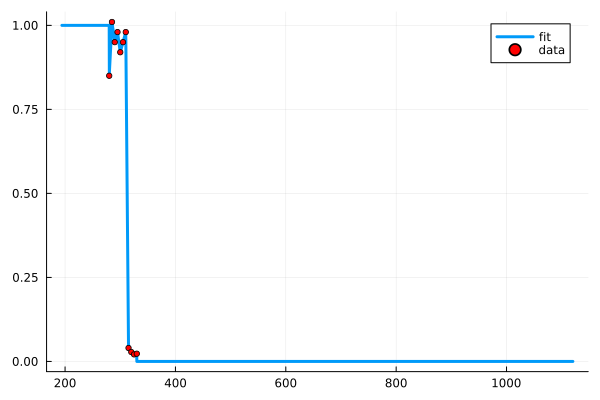

In [9]:
using DataInterpolations

cs = LinearInterpolation(Φ, λ)
Φ_out = cs(hr4000_df.λ)

# set anything outside of λ range to 0 as well
Φ_out[Φ_out .< 0.0] .= 0.0
Φ_out[ hr4000_df.λ .≥ λ_max] .= 0.0
Φ_out[hr4000_df.λ .≤ λ_min] .= 1.0


plot(hr4000_df.λ, Φ_out, lw=3, label="fit")
scatter!(λ, Φ, color=:red, ms=3, label="data")

In [10]:
df_photolysis_Φ.Φ_17 = Φ_out

describe(df_photolysis_Φ)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,Φ_1,0.114981,0.0,0.0,1.0,0,Float64
2,Φ_2,0.885019,0.0,1.0,1.0,0,Float64
3,Φ_3,0.963542,0.0,1.0,1.0,0,Float64
4,Φ_4,0.214167,0.0,0.0,1.0,0,Float64
5,Φ_6,0.426121,0.0,0.0,1.0,0,Float64
6,Φ_5,0.00986771,0.0,0.0,0.344696,0,Float64
7,Φ_7,0.211623,0.0,0.0,1.0,0,Float64
8,Φ_8,0.945175,0.0,1.0,1.0,0,Float64
9,Φ_11,0.0470227,0.0,0.0,0.73106,0,Float64


In [11]:
CSV.write("../photolysis_Φ.csv", df_photolysis_Φ)

"../photolysis_Φ.csv"